# Example OpenTISim with OpenCLSim for the full supply chain

## 0. Import packages and initialise objects

### Import Packages

In [1]:
### import datetime, time
import numpy as np
import numpy.matlib as npml
import pandas as pd
import statistics as st
from copy import deepcopy

import networkx as nx
import simpy

import matplotlib.pyplot as plt
from simplekml import Kml, Style   # for graph_kml
import math

import shapely.geometry
import pyproj

import pandas as pd
from opentisim.liquidbulk.hydrogen_defaults import *
from opentisim.liquidbulk.hydrogen_objects import *
import opentisim

# OpenCLSim
import openclsim
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

### Initialise Supply Chains, objects and transport modes

In [2]:
class SupplyChain:
    """This class implements a 'supply chain'.
    - name: supplychain name
    - origin: geometry indicating the origin
    - destination: geometry indicating the destination
    - elements: list of objects that can be used to transport goods (vessels, trucks, etc)
    - modal split: indicating a split
    """

    def __init__(self, 
                 name='Supply chain',
                 elements=[],
                 origin='from_site',
                 origin_latent_demand = 0,
                 origin_online_throughput = 0,
                 destination='mid_site',
                 destination_latent_demand = 0,
                 destination_online_throughput = 0,
                 capacity=None,
                 condition=[],
                 modalsplit=None
                 ):
        # identity
        self.name = name

        # collection of all terminal objects
        self.elements = elements

         # time inputs
        self.origin = origin
        self.origin_latent_demand = origin_latent_demand
        self.origin_online_throughput = origin_online_throughput
        self.destination = destination
        self.destination_latent_demand = destination_latent_demand
        self.destination_online_throughput = destination_online_throughput
        self.capacity = capacity
        self.condition = condition
        self.modalsplit = modalsplit

#### Create Site, Transport and Boil-off objects 

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
    ),
    {},
)

BoiloffResource = type(
    "Boil-off",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        #openclsim.core.LoadingFunction,
        #openclsim.core.UnloadingFunction,
    ),
    {},
)

## 1. Initiate simulation

for year in years:

* Step 1.1: Prepare Model set-up
    * Step 1.1.1.: Prepare graph (choose origin and destination) 
    * Step 1.1.2.: Choose Carrier and model time
* Step 1.2: Add properties to the graph
    * Step 1.2.1: Assign throughput scenarios to nodes
    * Step 1.2.2: Assign OpenTISim terminal elements to nodes
    * Step 1.2.3: Identify active supply chains
* Step 1.3: Step through years, and through the active supply chains
    * First we make terminal simulations
    * Next we attempt to simulate logistics with OpenCLSim (using storage capacities from OpenTISim) 

### 1.1 Prepare Model set-up

#### 1.1.1. Prepare graph 

In [4]:
phi =  51.88121982094231 #latitude 
lamb = 4.268813386454553 #longitude 

phirad = phi * np.pi / 180
lambrad = lamb*np.pi / 180

theta = 10 #bearing 
thetarad = theta * np.pi / 180

d =  12_500 #10_000 #km distance travelled  #xxx
R =  6371 #km earths radius 
delta = d/R #angular distance 

import math

lat2 = math.asin(math.sin(phirad)*math.cos(d/R) + math.cos(phirad)*math.sin(d/R)*math.cos(thetarad))
phirad2 = lat2
lon2 = lambrad + math.atan2(math.sin(thetarad)*math.sin(d/R)*math.cos(phirad), 
                           math.cos(d/R)-math.sin(phirad)*math.sin(phirad2))


londeg = lon2 * 180 / np.pi
latdeg = lat2 * 180 / np.pi
print(latdeg)
print(londeg)

15.18823804353157
174.69382432800919


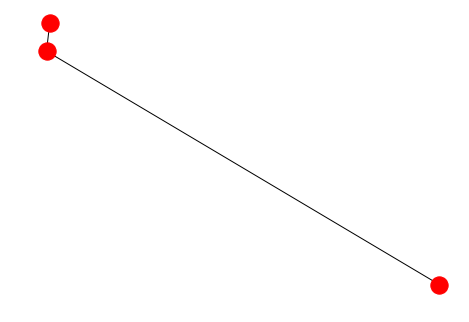

In [5]:
# path as clicked with Google Earth
#(151.218002,-33.976002) Sydney AUS
# path = [(-8.887295356404051,37.94869396789168), # Sines PT
#         (4.268813386454553,51.88121982094231)] # Botlek NL 

path = [ (londeg , latdeg),     # 10_000km 
        (4.268813386454553,51.88121982094231),# Botlek NL 
        (5.674868835166208, 56.30182413509039)] #500 km? 
        
        #(5.8277247,50.9672139)] # Geleen NL

# convert clicked path to networkx graph and draw
FG, positions, names = opentisim.core.convert_path_to_graph(path)
nx.draw(FG, positions)
FG.nodes

origin = shapely.geometry.Point(londeg,latdeg)
mid_destination = shapely.geometry.Point(4.268813386454553,51.88121982094231)
end_destination = shapely.geometry.Point(5.674868835166208, 56.30182413509039)

# inspect graph on Google Earth
# graph_kml(
#     FG,
#     fname="supplychain.kml")

In [6]:
# Using 'path' the graph's nodes are automatically named: 'node-0', 'node-1', 'node-2', etc. Lets rename:

# prepare mapping
mapping = {
    'node-0':'from_site',  # from node
    'node-1':'mid_site',  # mid node 
    'node-2': 'to_site'
          }

# apply mapping to graph object
FG = nx.relabel_nodes(FG, mapping)
FG.nodes

NodeView(('from_site', 'mid_site', 'to_site'))

#### 1.1.2. Choose carrier and model time 

- startyear 
- lifecycle 
- Carrier = MCH, liquid hydrogen, ammonia
- Place of the plant: centralized, decentralized 
- Transport supply chain 1 = Vessel 
- Transport supply chain 2 = barge, train, truck, pipe 
- Demand hydrogen at end user 

If the plant is decentralized:
- barge, train, truck and an nh3 pipe is possible

If the plant is centralized:
- CGH2 truck or CGH2 pipe is possible

In [7]:
#xxx
startyear = 2020
lifecycle = 10 
years = list(range(startyear, startyear+lifecycle))
carrier = 'MCH' #'liquid hydrogen', MCH, ammonia
place = 'decentralized'
transport_sc1 = 'vessel'
transport_sc2 = 'barge' #truck, train
demand_hydrogen = 2_000_000

if place == 'decentralized':
    sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
    sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage'}
    sc_enduse = {'storage','h2_retrieval'}
if place == 'centralized':
    sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
    sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_retrieval'}
    sc_enduse = {'storage'} 
    
# if place = 'centralized':
#     carrier2 = 'CGH2'

In [8]:
# error messages if supply chain can't be reality 

if place == 'centralized' and (transport =='barge' or transport == 'train'):
    print('error: centralized plant cannot have barge or train transport after')
    #exit()

#### 1.1.3 Find the carrier defaults 

In [9]:
if carrier == 'liquid hydrogen':
    commodity_type_defaults = commodity_lhydrogen_data
    storage_type_defaults = storage_lh2_data
    h2conversion_type_defaults = h2conversion_lh2_data
    h2retrieval_type_defaults = h2retrieval_lh2_data
    vessel_defaults = largehydrogen_data
    barge_defaults = hydrogen_barge_data
    train_defaults = hydrogen_train_data
    truck_defaults = truck_lh2_data
        
if carrier == 'ammonia':
    commodity_type_defaults = commodity_ammonia_data
    storage_type_defaults = storage_nh3_data
    h2conversion_type_defaults = h2conversion_nh3_data
    h2retrieval_type_defaults = h2retrieval_nh3_data
    vessel_defaults = largeammonia_data
    barge_defaults = ammonia_barge_data
    train_defaults = ammonia_train_data
    truck_defaults = truck_nh3_data

if carrier == 'MCH':
    commodity_type_defaults = commodity_MCH_data
    storage_type_defaults = storage_MCH_data
    h2conversion_type_defaults = h2conversion_MCH_data
    h2retrieval_type_defaults = h2retrieval_MCH_data
    vessel_defaults = vlcc_data
    barge_defaults = MCH_barge_data
    train_defaults = MCH_train_data
    truck_defaults = truck_MCH_data

In [10]:
loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60

print(loadingtime_ship/60/60)

13.0


In [11]:
def character_shippingroute(origin, destination, transport_defaults,carrier):
    if transport_defaults == vessel_defaults:
        capacity_ship = vessel_defaults["call_size"]
        pump_ship = vessel_defaults["pump_capacity"]
        loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
        unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
        velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
        losses_ship = vessel_defaults['losses']
        
    if transport_defaults == barge_defaults:
        capacity_ship = barge_defaults ["call_size"]
        loadingtime_ship = (barge_defaults["loadingtime"])*60*60
        unloadingtime_ship = (barge_defaults["unloadingtime"])*60*60
        velocity_ship = barge_defaults["avspeed"]/3.6 # #25 km/h --> m/s 
        losses_ship = barge_defaults['losses']
        
    if transport_defaults == train_defaults:
        capacity_ship = train_defaults ["call_size"]
        loadingtime_ship = (train_defaults ["loadingtime"])*60*60
        unloadingtime_ship = (train_defaults ["unloadingtime"])*60*60
        velocity_ship = train_defaults ["avspeed"]/3.6 # #25 km/h --> m/s 
        losses_ship = train_defaults ['losses']
        
    if transport_defaults == truck_defaults:
        capacity_ship = truck_defaults ["capacity"]
        loadingtime_ship = (truck_defaults["loadingtime"])*60*60
        unloadingtime_ship = (truck_defaults["unloadingtime"])*60*60
        velocity_ship = truck_defaults["avspeed"]/3.6 # #25 km/h --> m/s 
        losses_ship = truck_defaults['losses']

    wgs84 = pyproj.Geod(ellps="WGS84")
    orig = shapely.geometry.asShape(origin)
    dest = shapely.geometry.asShape(destination)
    _, _, distance = wgs84.inv(orig.x, orig.y, dest.x, dest.y) #distance in m 
    
    v = lambda x: velocity_ship #default: ship velocity in m/s 
    current_speed = v 
    
    if carrier == 'MCH':
        loading = 2 * loadingtime_ship 
        unloading = 2 * unloadingtime_ship
    else:
        loading = loadingtime_ship  #default: ship loading time #in seconds: 
        unloading = unloadingtime_ship #default: ship unloading time
    
    capacity_ship = capacity_ship  #default: ship capacity 
    secyear = 60*60*24*365
    
    engine_order = 1 
    duration = distance/((current_speed) (engine_order))
    
    distancekm = distance/1000
    durationdays = duration/60/60/24
    #print(distance/1000, 'distance in km')
    #print(duration/60/60/24, 'in days')
    
    onetriptime = loading + duration + unloading + duration 
    numberoftrips = math.ceil(secyear / onetriptime)#6  #7.48 #math.ceil(secyear / onetriptime)
    maxtrans1 = numberoftrips * capacity_ship 
    
    #print(maxtrans1, 'maximum volume that can be transferred from from_site to mid_site') #1019700 max trans for origin to midsite 

    bog = losses_ship #%/d default
    ton = capacity_ship #ton LH2 default 

    days = math.ceil(durationdays) #math.ceil math.floor

    bogtot = np.zeros(days)
    bogtot[0] = ton*(100-bog)/100

    for i in range(days-1):
        bogtot[i+1] = bogtot[i] - ((bog*bogtot[i])/100) 
        
    totloss = 100-((100*bogtot[-1])/ton)
    transloss = totloss
    #print(transloss)

    lossofload = ton - ((100-transloss)*ton/100)
    #print(lossofload)
    
    return distancekm, durationdays, maxtrans1, transloss, lossofload,numberoftrips

In [12]:
if transport_sc1 == 'vessel':
    transport_defaults_sc1 = vessel_defaults
distancekm_sc1, durationdays_sc1, maxtrans_sc1, transloss_sc1, lossofload_sc1, numberoftrips_sc1 = character_shippingroute(origin, mid_destination, transport_defaults_sc1,carrier)

if transport_sc2 == 'barge':
    transport_defaults_sc2 = barge_defaults 
if transport_sc2 == 'train':
    transport_defaults_sc2 = train_defaults 
if transport_sc2 == 'truck':
    transport_defaults_sc2 = truck_defaults 

distancekm_sc2, durationdays_sc2, maxtrans_sc2, transloss_sc2, lossofload_sc2, numberoftrips_sc2 = character_shippingroute(mid_destination, end_destination, transport_defaults_sc2,carrier)

print('---------the supply chain from the export terminal to the import terminal-----------')
print('distance is',distancekm_sc1, 'km')
print('one trip takes',durationdays_sc1,'days' )
print('one vessel can transport a maximum of',maxtrans_sc1, 'ton in 1 year')
print('the transport loss is equal to', transloss_sc1, '% per trip')
print('the loss of the load of 1 trip is', lossofload_sc1, 'ton')
print('the number of trips a vessel makes in a year is', numberoftrips_sc1)

print('---------the supply chain from the import terminal to the end-use location-----------')
print('distance is',distancekm_sc2, 'km')
print('one trip takes',durationdays_sc2,'days' )
print('one vessel can transport a maximum of',maxtrans_sc2, 'ton in 1 year')
print('the transport loss is equal to', transloss_sc2, '% per trip')
print('the loss of the load of 1 trip is', lossofload_sc2, 'ton')
print('the number of trips a vessel makes in a year is', numberoftrips_sc2)


---------the supply chain from the export terminal to the import terminal-----------
distance is 12516.66889190618 km
one trip takes 20.861114819843632 days
one vessel can transport a maximum of 1800000 ton in 1 year
the transport loss is equal to 0.0 % per trip
the loss of the load of 1 trip is 0.0 ton
the number of trips a vessel makes in a year is 9
---------the supply chain from the import terminal to the end-use location-----------
distance is 500.5407878307989 km
one trip takes 1.604297396893586 days
one vessel can transport a maximum of 254100 ton in 1 year
the transport loss is equal to 0.0 % per trip
the loss of the load of 1 trip is 0.0 ton
the number of trips a vessel makes in a year is 33


##### Find losses

In [13]:
jetty_loss = jetty_pipeline_data['losses']
recplant_loss = h2retrieval_type_defaults['losses']
conplant_loss = h2conversion_type_defaults['losses']
storage_loss_end = storage_type_defaults['losses']*15
storage_loss = storage_type_defaults['losses']*30
transport_loss_sc1 = transloss_sc1 
transport_loss_sc2 = transloss_sc2
Hcontent = commodity_type_defaults['Hcontent']
capacity_ship = barge_defaults["call_size"]
print(capacity_ship)

7700


### 1.2 Add properties to the graph
#### 1.2.1 Assign throughput scenarios to nodes

In [14]:
nx.set_node_attributes(FG, [], 'througput')

#### 1.2.2 Calculate the Supply and Demand

For the specific carrier the supply and demand is given in tonnes of carrier. 
The supply is based on the demand and the demand is given in ton H2. 
For a carrier the demand needs to be converted from hydrogen to carrier. 
The supply needs to be converted for the demand with the added losses. 

In [15]:
#demand at end-user is 2,000,000 H2 
#place of plant is decentralized 
if place == 'decentralized':
     #give the Demand that you need in tonnes of H2 
    demand_carrier1 = (demand_hydrogen * 100) / Hcontent #demand is converted to carrier 

    #end-use is dimensioned on this demand
    demand_enduse_out = demand_carrier1
    demand_enduse_in = (((storage_loss_end + recplant_loss)+100)*demand_carrier1)/100

    #import terminal is dimensioned on this demand plus losses (import terminal out)
    demand_import_out = (((transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100
    demand_import_in = (((jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100

    #export terminal is dimensioned on this demand plus losses (export terminal out)
    demand_export_out = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100
    demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100

    #print(demand_enduse_out)
    #print(demand_export_in )
if place == 'centralized':
    #give the Demand that you need in tonnes of H2 
    demand_carrier1 = (demand_hydrogen * 100) / Hcontent #demand is converted to carrier 

    #end-use is dimensioned on this demand
    demand_enduse_out = demand_carrier1
    demand_enduse_in = demand_carrier1

    #import terminal is dimensioned on this demand plus losses (import terminal out)
    demand_import_out = (((transloss_sc2)+100)*demand_carrier1)/100
    demand_import_in = (((jetty_loss+storage_loss+ recplant_loss +transloss_sc2 )+100)*demand_carrier1)/100

    #export terminal is dimensioned on this demand plus losses (export terminal out)
    demand_export_out = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier1)/100
    demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier1)/100

    #print(demand_enduse_out)
    #print(demand_export_in )
print(demand_carrier1) 
print(demand_enduse_out)
print(demand_import_out)
print(demand_export_out)
print(Hcontent)

32258064.51612903
32258064.51612903
35483870.96774194
35483870.96774194
6.2


######  from_site: create and add a supply throughput 

The export terminal is dimensioned on the demand that has to go in to the vessel. 

In [16]:
# create a supply at the from_site
#supply = list(np.matlib.repmat(2_036_000,1,len(years))[0])

supply = []
for year in years:
    if year < 2025:
        supply.append(demand_export_out) #(2_000_000 H2)
    else:
        supply.append(demand_export_out) #(4_000_000 H2)
        
throughput_from = pd.DataFrame({'year': years, 
                     'volume': supply})
print(throughput_from)
FG.nodes['from_site']['througput'] = throughput_from

# print('Positive throuput is supply, negative throughput is demand')
# display(througput_from)

   year        volume
0  2020  3.548387e+07
1  2021  3.548387e+07
2  2022  3.548387e+07
3  2023  3.548387e+07
4  2024  3.548387e+07
5  2025  3.548387e+07
6  2026  3.548387e+07
7  2027  3.548387e+07
8  2028  3.548387e+07
9  2029  3.548387e+07


######  mid_site: create and add a demand throughput 

The import terminal is dimensioned on the demand that has to come out of the reconversion plant (converted to carrier).

In [17]:
# create a demand at the mid_site
# demand = list(npml.repmat(2_000_000,1,len(years))[0])

demand_mid = []
for year in years:
    if year < 2025:
        demand_mid.append(demand_import_out) #(2_000_000 H2)
    else:
        demand_mid.append(demand_import_out) #(4_000_000 H2)
        
#demand = list(npml.repmat(20_000_000,1,len(years))[0])
throughput_mid = pd.DataFrame({'year': years, 
                     'volume': demand_mid})

print(throughput_mid)
FG.nodes['mid_site']['througput'] = throughput_mid

# print('Positive throuput is supply, negative throughput is demand')
# display(throughput_end)

   year        volume
0  2020  3.548387e+07
1  2021  3.548387e+07
2  2022  3.548387e+07
3  2023  3.548387e+07
4  2024  3.548387e+07
5  2025  3.548387e+07
6  2026  3.548387e+07
7  2027  3.548387e+07
8  2028  3.548387e+07
9  2029  3.548387e+07


######  to_site: create and add a demand throughput 

The end use location is dimensioned on the end-user demand

In [18]:
# create a demand at the mid_site
# demand = list(npml.repmat(2_000_000,1,len(years))[0])

demand_end = []
for year in years:
    if year < 2025:
        demand_end.append(demand_enduse_out) #(2_000_000 H2)
    else:
        demand_end.append(demand_enduse_out) #(4_000_000 H2)
        
#demand = list(npml.repmat(20_000_000,1,len(years))[0])
throughput_to = pd.DataFrame({'year': years, 
                     'volume': demand_end})

print(throughput_to)
FG.nodes['to_site']['througput'] = throughput_to

# print('Positive throuput is supply, negative throughput is demand')
# display(throughput_end)

   year        volume
0  2020  3.225806e+07
1  2021  3.225806e+07
2  2022  3.225806e+07
3  2023  3.225806e+07
4  2024  3.225806e+07
5  2025  3.225806e+07
6  2026  3.225806e+07
7  2027  3.225806e+07
8  2028  3.225806e+07
9  2029  3.225806e+07


#### 1.2.2 Assign terminal objects to nodes

In [19]:
# add an empty terminal property
nx.set_node_attributes(FG, [], 'terminal')

# add an empty OpenCLSim Site property
nx.set_node_attributes(FG, [], 'site')

###### From_site:
instantiate demand

In [20]:
if carrier == 'liquid hydrogen':
    commodity_lhydrogen_data['smallhydrogen_perc'] = 0
    commodity_lhydrogen_data['largehydrogen_perc'] = 100
    commodity_lhydrogen_data['historic_data'] = []
    commodity_lhydrogen_data['scenario_data'] = []
    lhydrogen = Commodity(**commodity_lhydrogen_data)
    lhydrogen.scenario_data = throughput_from
    demand = [lhydrogen] 
    
if carrier == 'ammonia':
    commodity_ammonia_data["smallammonia_perc"] = 0
    commodity_ammonia_data["largeammonia_perc"] = 100
    commodity_ammonia_data['historic_data'] = []
    commodity_ammonia_data['scenario_data'] = []
    ammonia = Commodity(**commodity_ammonia_data)
    ammonia.scenario_data = throughput_from  #choose what carrier
    demand = [ammonia] 
    
if carrier == 'MCH':
    commodity_MCH_data["handysize_perc"] = 0
    commodity_MCH_data["panamax_perc"] = 0
    commodity_MCH_data["vlcc_perc"] = 100
    commodity_MCH_data['historic_data'] = []
    commodity_MCH_data['scenario_data'] = []
    MCH = Commodity(**commodity_MCH_data)
    MCH.scenario_data = throughput_from  #choose what carrier
    demand = [MCH] 

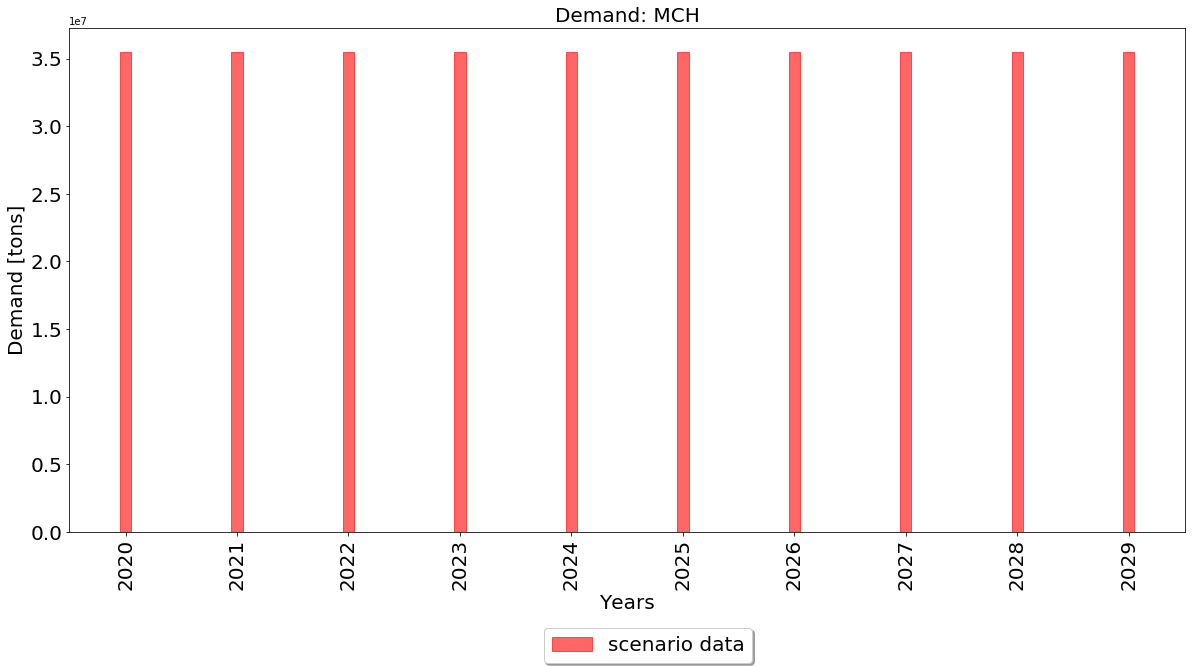

In [21]:
if carrier == 'liquid hydrogen':
    lhydrogen.plot_demand()
    
if carrier == 'ammonia':
    ammonia.plot_demand()
    
if carrier == 'MCH':
    MCH.plot_demand()

In [22]:
# instantiate vessels
Smallhydrogen = Vessel(**smallhydrogen_data)
Largehydrogen = Vessel(**largehydrogen_data)
Smallammonia = Vessel(**smallammonia_data)
Largeammonia = Vessel(**largeammonia_data)
Handysize = Vessel(**handysize_data)
Panamax = Vessel(**panamax_data)
VLCC = Vessel(**vlcc_data)

# vessels variable: contains info on vessels (to be added to Terminal.elements)
vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

##### From_site: Instantiate Export Terminal

In [23]:
if carrier == 'MCH':
    dwelltime =45/365
else:
    dwelltime = 30/365

# Instantiate OpenTISim Terminal
from_site_terminal = opentisim.liquidbulk.ExportTerminal(
            startyear = None, 
            lifecycle = 1, 
            elements = demand + vessels, 
            operational_hours = 16*365,   # example Wijnand
            terminal_supply_chain=sc_export,
            debug=False,
            commodity_type_defaults=commodity_type_defaults,
            storage_type_defaults=storage_type_defaults,
            kendall='E2/E2/n',
            allowable_waiting_service_time_ratio_berth=0.3,
            h2conversion_type_defaults=h2conversion_type_defaults,
            allowable_dwelltime= dwelltime)

from_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
from_site_terminal.revenues = []
from_site_terminal.demurrage = []

# add an OpenTISim Terminal to the graph
FG.nodes['from_site']['terminal'] = from_site_terminal

##### Mid_site: 

Instantiate Demand

In [24]:
if carrier == 'liquid hydrogen':
    commodity_lhydrogen_data['smallhydrogen_perc'] = 0
    commodity_lhydrogen_data['largehydrogen_perc'] = 100
    commodity_lhydrogen_data['historic_data'] = []
    commodity_lhydrogen_data['scenario_data'] = []
    lhydrogen = Commodity(**commodity_lhydrogen_data)
    lhydrogen.scenario_data = throughput_mid
    demand = [lhydrogen] 
    
if carrier == 'ammonia':
    commodity_ammonia_data["smallammonia_perc"] = 0
    commodity_ammonia_data["largeammonia_perc"] = 100
    commodity_ammonia_data['historic_data'] = []
    commodity_ammonia_data['scenario_data'] = []
    ammonia = Commodity(**commodity_ammonia_data)
    ammonia.scenario_data = throughput_mid  #choose what carrier
    demand = [ammonia] 

if carrier == 'MCH':
    commodity_MCH_data["handysize_perc"] = 0
    commodity_MCH_data["panamax_perc"] = 0
    commodity_MCH_data["vlcc_perc"] = 100
    commodity_MCH_data['historic_data'] = []
    commodity_MCH_data['scenario_data'] = []
    MCH = Commodity(**commodity_MCH_data)
    MCH.scenario_data = throughput_mid  #choose what carrier
    demand = [MCH] 

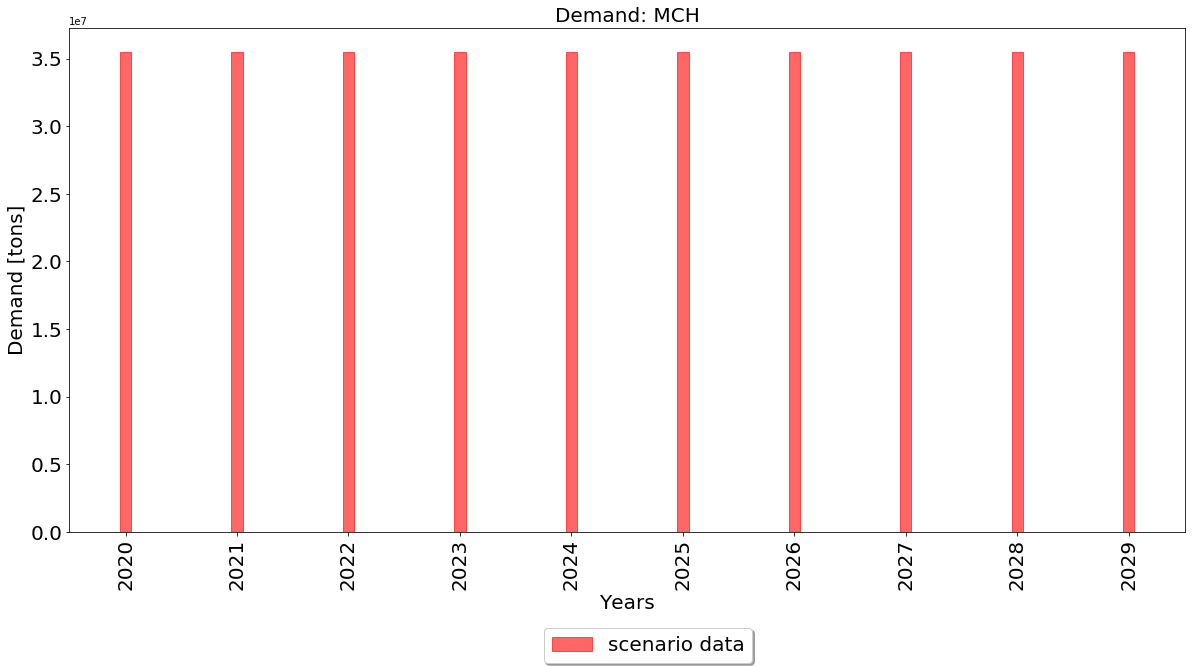

In [25]:
if carrier == 'liquid hydrogen':
    lhydrogen.plot_demand()
    
if carrier == 'ammonia':
    ammonia.plot_demand()
    
if carrier == 'MCH':
    MCH.plot_demand()

In [26]:
# instantiate vessels
Smallhydrogen = Vessel(**smallhydrogen_data)
Largehydrogen = Vessel(**largehydrogen_data)
Smallammonia = Vessel(**smallammonia_data)
Largeammonia = Vessel(**largeammonia_data)
Handysize = Vessel(**handysize_data)
Panamax = Vessel(**panamax_data)
VLCC = Vessel(**vlcc_data)

# vessels variable: contains info on vessels (to be added to Terminal.elements)
vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

In [27]:
if carrier == 'MCH':
    dwelltime = 45/365
else:
    dwelltime = 30/365

# Instantiate OpenTNSim Terminal
mid_site_terminal =  opentisim.liquidbulk.System(
            startyear = None, 
            lifecycle = 1, 
            elements = demand + vessels, 
            operational_hours = 16*365,   # example Wijnand
            terminal_supply_chain=sc_import,
            debug=False,
            commodity_type_defaults=commodity_type_defaults,
            storage_type_defaults=storage_type_defaults,
            kendall='E2/E2/n',
            allowable_waiting_service_time_ratio_berth=0.3,
            h2retrieval_type_defaults=h2retrieval_type_defaults,
            allowable_dwelltime= dwelltime)


mid_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
mid_site_terminal.revenues = []
mid_site_terminal.demurrage = []
mid_site_terminal.transport_sc2 = transport_sc2

# # add an OpenTNSim Terminal to the graph
# FG.nodes['from_site']['terminal'] = from_site_terminal

# add an OpenTISim Terminal to the graph
FG.nodes['mid_site']['terminal'] = mid_site_terminal

##### End_site: 

Instantiate Demand

In [28]:
if carrier == 'liquid hydrogen':
    commodity_lhydrogen_data['smallhydrogen_perc'] = 0
    commodity_lhydrogen_data['largehydrogen_perc'] = 100
    commodity_lhydrogen_data['historic_data'] = []
    commodity_lhydrogen_data['scenario_data'] = []
    lhydrogen = Commodity(**commodity_lhydrogen_data)
    lhydrogen.scenario_data = throughput_to
    demand = [lhydrogen] 
    
if carrier == 'ammonia':
    commodity_ammonia_data["smallammonia_perc"] = 0
    commodity_ammonia_data["largeammonia_perc"] = 100
    commodity_ammonia_data['historic_data'] = []
    commodity_ammonia_data['scenario_data'] = []
    ammonia = Commodity(**commodity_ammonia_data)
    ammonia.scenario_data = throughput_to  #choose what carrier
    demand = [ammonia] 

if carrier == 'MCH':
    commodity_MCH_data["handysize_perc"] = 0
    commodity_MCH_data["panamax_perc"] = 0
    commodity_MCH_data["vlcc_perc"] = 100
    commodity_MCH_data['historic_data'] = []
    commodity_MCH_data['scenario_data'] = []
    MCH = Commodity(**commodity_MCH_data)
    MCH.scenario_data = throughput_to  #choose what carrier
    demand = [MCH] 

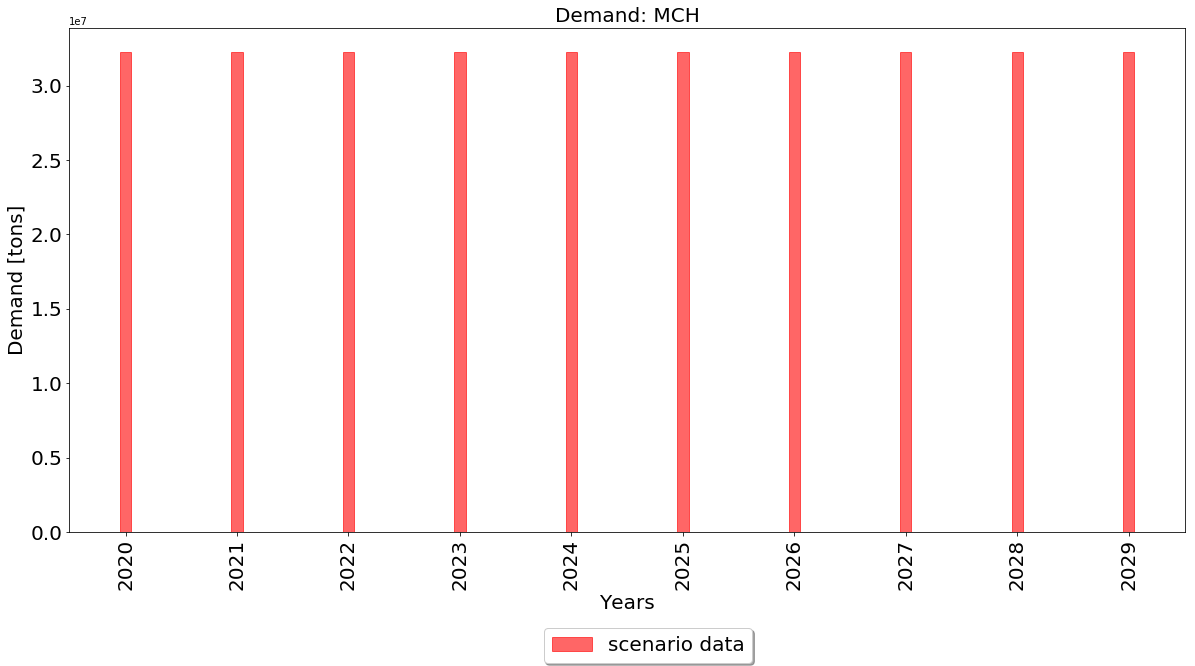

In [29]:
if carrier == 'liquid hydrogen':
    lhydrogen.plot_demand()
    
if carrier == 'ammonia':
    ammonia.plot_demand()
    
if carrier == 'MCH':
    MCH.plot_demand()

In [30]:
if carrier == 'MCH':
    dwelltime = 30/365
else:
    dwelltime = 15/365

# Instantiate OpenTNSim Terminal
to_site_terminal =  opentisim.liquidbulk.EndUseLocation(
            startyear = None, 
            lifecycle = 1, 
            elements = demand, 
            operational_hours = 16*365,   # example Wijnand
            terminal_supply_chain= sc_enduse,
            debug=False,
            commodity_type_defaults=commodity_type_defaults,
            storage_type_defaults=storage_type_defaults,
            h2retrieval_type_defaults=h2retrieval_type_defaults,
            allowable_dwelltime= dwelltime)


to_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
to_site_terminal.revenues = []
to_site_terminal.demurrage = []
to_site_terminal.place = place

# # add an OpenTNSim Terminal to the graph
# FG.nodes['from_site']['terminal'] = from_site_terminal

# add an OpenTISim Terminal to the graph
FG.nodes['to_site']['terminal'] = to_site_terminal

#### 1.2.3 Identify active supply chains

In [31]:
supplychain_1 = SupplyChain(
    name='Supplychain 1',
    elements = [],
    origin = 'from_site',
    origin_latent_demand = 0,
    origin_online_throughput = 0,
    destination='mid_site',
    destination_latent_demand = 0,
    destination_online_throughput = 0,
    condition=[{"type": "container", "concept": 'from_site', "state": "empty"}],
    capacity=None)

In [32]:
supplychain_2 = SupplyChain(
    name='Supplychain 2',
    elements = [],
    origin = 'mid_site',
    origin_latent_demand = 0,
    origin_online_throughput = 0,
    destination='to_site',
    destination_latent_demand = 0,
    destination_online_throughput = 0,
    condition=[{"type": "container", "concept": 'mid_site', "state": "empty"}],
    capacity=None)

In [33]:
supplychains = [supplychain_1, supplychain_2]

#### Find ship and transport characteristics

In [34]:
capacity_ship = vessel_defaults["call_size"]
pump_ship = vessel_defaults["pump_capacity"]
loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
losses_ship = transloss_sc1

if transport_sc2 == 'barge':
    capacity_barge = barge_defaults["call_size"]
    loadingtime_barge = (barge_defaults["loadingtime"])*60*60
    unloadingtime_barge = (barge_defaults["unloadingtime"])*60*60
    velocity_barge = barge_defaults['avspeed']/3.6
    losses_barge = transloss_sc2
if transport_sc2 == 'train':
    capacity_barge = train_defaults["call_size"]
    loadingtime_barge = (train_defaults["loadingtime"])*60*60
    unloadingtime_barge = (train_defaults["unloadingtime"])*60*60
    velocity_barge = train_defaults['avspeed']/3.6
    losses_barge = transloss_sc2
if transport_sc2 == 'truck':
    capacity_barge = truck_defaults["capacity"]
    loadingtime_barge = (truck_defaults["loadingtime"])*60*60
    unloadingtime_barge = (truck_defaults["unloadingtime"])*60*60
    velocity_barge = truck_defaults['avspeed']/3.6
    losses_barge = transloss_sc2
    
if carrier == 'MCH':
    loadingtime_ship = 2*loadingtime_ship
    unloadingtime_ship = 2*unloadingtime_ship
    loadingtime_barge = 2*(barge_defaults["loadingtime"])*60*60
    unloadingtime_barge = 2*(barge_defaults["unloadingtime"])*60*60


# Run Terminals and Transport

This code runs the export and import terminal for each year and it shows how many vessels are needed each year to empty the from_site

In [ ]:
Debug = False
debug = True

commodity_lhydrogen_data['scenario_data'] = []
commodity_ammonia_data['scenario_data'] = []
commodity_MCH_data['scenario_data'] = []
dataframe_openclsim = []
dataframe_openclsim2 = []

startyear = 2020
lifecycle = 10 

years = list(range(startyear, startyear+lifecycle))
years1 =  list(range(startyear, startyear+lifecycle))
years2 = list(range(startyear+2,startyear+lifecycle))


for index_year,year in enumerate(years):
    for supplychain in supplychains:
        count_vessel = 0 
        count_transport = 0 
        FG.nodes[supplychain.origin]['site'] = []
        FG.nodes[supplychain.destination]['site'] = []
    # OpenTISim: op 1 januari neem je al je beslissingen (terminals + supply chains)
    if debug == True:
        print('')
        print('simulation for year: {} ---------------'.format(year))
    
    for supplychain in supplychains:
        # 1. als de origin node in de supplychain een throughput property heeft, 
        # bereken dan de benodigde terminal dimensies
        throughput_online_origin = 0
        if type(FG.nodes[supplychain.origin]['througput']) == pd.core.frame.DataFrame:
            FG.nodes[supplychain.origin]['terminal'].startyear = year
            FG.nodes[supplychain.origin]['terminal'].debug = Debug
            #FG.nodes[supplychain.origin]['terminal'].years = years1
            #print(FG.nodes[supplychain.origin]['terminal'].__dict__)
            FG.nodes[supplychain.origin]['terminal'].simulate()
            
            throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
    
            if debug == True:
                print('Terminal: {}, year: {}, throughput online: {}'.format(supplychain.origin, year, throughput_online_origin))
                print('')
                print()

            #supplychain.origin_online_throughput = throughput_online_jetty_origin
            supplychain.origin_online_throughput = throughput_online_origin
            
         # 2. als de destination node in de supplychain een throughput property heeft, 
        # bereken dan de benodigde terminal dimensies
        throughput_online_destination = 0
        if type(FG.nodes[supplychain.destination]['througput']) == pd.core.frame.DataFrame:
            
            FG.nodes[supplychain.destination]['terminal'].startyear = year
            FG.nodes[supplychain.destination]['terminal'].debug = Debug
            #FG.nodes[supplychain.destination]['terminal'].years = years1
            FG.nodes[supplychain.destination]['terminal'].simulate()
            
            throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_destination))
                print('')
            
            supplychain.destination_online_throughput = throughput_online_jetty_in_dest
            
        # 3. als de origin een throughput heeft, maar de destination niet,
        # voeg dan de throughput van de origin toe aan die van de destination 
        if throughput_online_origin != 0 and throughput_online_destination == 0:
            if debug == True:
                print('The origin is generating throughput. I need a latent demand in the destination location.')

#             The origin is generating throughput. I need a latent demand in the destination location.
#             Terminal: mid_site, year: 2004, throughput: 1617850.649350649

            #supplychain.destination_latent_demand = throughput_online_jetty_origin
            supplychain.destination_latent_demand = throughput_online_origin

            # Use the throughput at the other end of the supply chain as a latent demand

            # Liquid hydrogen
            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['historic_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                demand = [lhydrogen]
                #print(lhydrogen.scenario_data)
            

            # Ammonia
            if carrier == 'ammonia':
                commodity_ammonia_data['historic_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                demand = [ammonia]

            # MCH
            if carrier == 'MCH': 
                commodity_MCH_data['historic_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                demand = [MCH]

            
            # adopt vessels from the other node
            vessels = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) == Vessel]
            
            # find all terminal_elements that are NOT a commodity
            terminal_elements = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

            # add terminal_elements + new demands
            FG.nodes[supplychain.destination]['terminal'].elements = terminal_elements + demand + vessels
            
            FG.nodes[supplychain.destination]['terminal'].startyear = year
            FG.nodes[supplychain.destination]['terminal'].debug = Debug
            FG.nodes[supplychain.destination]['terminal'].years = years2
            FG.nodes[supplychain.destination]['terminal'].simulate()

            throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_jetty_destination))
                print('')
            
            #supplychain.destination_online_throughput = throughput_online_jetty_destination
            supplychain.destination_online_throughput = throughput_online_jetty_in_dest
            
            
        # 4. als de origin geen throughput heeft, maar de destination wel,
        # voeg dan de throughput van de destination toe aan die van de origin 
        if throughput_online_origin == 0 and throughput_online_destination != 0:
            if debug == True:
                print('The destination is generating throughput. I need latent demand in the origin location')
            
            supplychain.origin_latent_demand = throughput_online_jetty_in_dest #throughput_online_jetty_destination

            # Use the throughput at the other end of the supply chain as a latent demand
            supply = list(np.matlib.repmat(throughput_online_jetty_destination,1,1)[0])
            througput_origin = pd.DataFrame({'year': year, 'volume': supply})

            # Liquid hydrogen
            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['historic_data'] = []
                #lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)

                if lhydrogen.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    lhydrogen.scenario_data = lhydrogen.scenario_data
                    #print('true')
                else:
                    lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                    #print('false')
                demand = [lhydrogen]
            
            if carrier == 'ammonia':
                commodity_ammonia_data['historic_data'] = []
                if ammonia.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    ammonia.scenario_data = ammonia.scenario_data
                    #print('true')
                else:
                    ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                    #print('false')
                demand = [ammonia]
            
            if carrier == 'MCH':
                commodity_MCH_data['historic_data'] = []
                if MCH.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    MCH.scenario_data = MCH.scenario_data
                    #print('true')
                else:
                    MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                    #print('false')
                demand = [MCH]
                    
            
            # adopt vessels from the other node
            vessels = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) == Vessel]
            
            # find all terminal_elements that are NOT a commodity
            terminal_elements = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

            # add terminal_elements + new demands
            FG.nodes[supplychain.origin]['terminal'].elements = terminal_elements + demand + vessels

            FG.nodes[supplychain.origin]['terminal'].startyear = year
            FG.nodes[supplychain.origin]['terminal'].debug = Debug
            FG.nodes[supplychain.origin]['terminal'].years = years2
            FG.nodes[supplychain.origin]['terminal'].simulate()

            throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.origin, year, throughput_online_jetty_origin))
                print('')

            supplychain.origin_online_throughput = throughput_online_origin

    # 5. run openclsim calculation
    # OpenCLSim: tussen 2 januari - 31 december ga je transporteren
    if supplychain.origin_online_throughput !=0 and supplychain.destination_online_throughput!=0:

        # step past all supplychains to initiate the sites and vessels
        for index, supplychain in enumerate(supplychains):
            
            if index == 0:

                #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                level_from_site = supplychain.origin_online_throughput
                level_mid_site = 0
                #activities = []
                while level_from_site != 0:
                    count_vessel += 1
                    if debug == True:
                        print('**Add a ship**')
                    #make environment 
                    #simulation_start  = datetime.datetime(year, 1, 1, 0, 0)
                    #my_env = simpy.Environment(initial_time=simulation_start.timestamp())
                    simulation_start = 0 
                    my_env = simpy.Environment(initial_time=simulation_start)
                   
                
                    # origin
                    capacity_from_site = max([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    data_from_site = {"env": my_env,
                                 "name": supplychain.origin,
                                 "geometry": FG.nodes[supplychain.origin]['geometry'],
                                 "capacity": capacity_from_site, 
                                 "level": level_from_site
                                 }
                    FG.nodes[supplychain.origin]['site'] = Site(**data_from_site)
                    from_site = Site(**data_from_site)
                    
                    # destination
                    capacity_mid_site = capacity_from_site #max([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    #level_to_site = min([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    data_mid_site = {"env": my_env,
                                 "name": supplychain.destination,
                                 "geometry": FG.nodes[supplychain.destination]['geometry'],
                                 "capacity": capacity_mid_site, 
                                 "level": level_mid_site #0
                                 }
                    FG.nodes[supplychain.destination]['site'] = Site(**data_mid_site)
                    mid_site = Site(**data_mid_site)
                    capacity_bog = capacity_mid_site
                    
                    boil_off_container = {"env": my_env,
                                 "name": 'boil-off',
                                  "geometry": FG.nodes[supplychain.destination]['geometry'],
                                  #"loading_rate": 0.00001,
                                 #"unloading_rate": 0.00001,
                                 "capacity": capacity_bog, 
                                  "compute_v": lambda x: 0
                                }


                    boil_off01 = BoiloffResource(**boil_off_container)
                    
                    if debug == True:
                        print('capacity at origin', capacity_from_site)
                        print('level at origin', level_from_site)
                        print('capacity at destination', capacity_mid_site)
                        print('level at destination', level_mid_site)
                    
                    # vessels
                    # prepare input data for vessel_01
                    data_vessel01 = {"env": my_env,
                                     "name": "vessel " + supplychain.name,
                                     "geometry": FG.nodes[supplychain.origin]['geometry'], 
                                     "loading_rate": 0.00001,
                                     "unloading_rate": 0.00001,
                                     "capacity": capacity_ship,
                                     "compute_v": lambda x: velocity_ship
                                    }
                
            
                    # instantiate vessel_01 
                    vessel01 = TransportProcessingResource(**data_vessel01)
                
                    supplychain.elements = [vessel01]

                    # use the sites from the graph and the vessels from the supplychains to construct activities
                    #activities = []

                    # initialise registry
                    registry = {}
                    if debug == True:
                        print('transporter activity between from_site and mid_site')

                    # create a list of the sub processes
                    requested_resources1 = {}

                    sub_processes = [
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing empty",
                            registry=registry,
                            mover=vessel01,
                            destination=from_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="loading",
                            registry=registry,
                            processor=vessel01,
                            origin=from_site,
                            destination=vessel01,
                            amount=capacity_ship,
                            duration=loadingtime_ship,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing full",
                            registry=registry,
                            mover=vessel01,
                            destination=mid_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="boil off",
                            registry=registry,
                            processor=vessel01,
                            origin=vessel01,
                            destination=boil_off01,
                            amount=lossofload_sc1,
                            duration=0,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="unloading",
                            registry=registry,
                            processor=vessel01,
                            origin=vessel01,
                            destination=mid_site,
                            amount=capacity_ship,
                            duration=unloadingtime_ship, #in seconds 
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.BasicActivity(
                            env=my_env,
                            name="basic activity",
                            registry=registry,
                            duration=0,
                            additional_logs=[vessel01],
                            requested_resources=requested_resources1,
                        ),
                    ]

                    # create a 'sequential activity' that is made up of the 'sub_processes'
                    sequential_activity = openclsim.model.SequentialActivity(
                        env=my_env,
                        name="sequential_activity_subcycle_1",
                        registry=registry,
                        sub_processes=sub_processes,
                    )
                    
                    #print(sub_processes[3])

                    # now the site has been created we can add the site variable to the condition
                    if level_from_site > maxtrans_sc1:#1019700:
                        condition = [{"type": "activity", "name": "while_sequential_activity_subcycle ", "state": "done"}]
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition,
                        )
                        
                        model.register_processes([while_activity])
                        secyear = 60*60*24*365
                        my_env.run(until = secyear)
                    else:
                        condition1 = [{"type": "container", "concept": from_site, "state": "empty"}]
                        
                        #change
                        sub_processes_new = sub_processes.pop(3)
                        
                        sequential_activity = openclsim.model.SequentialActivity(
                            env=my_env,
                            name="sequential_activity_subcycle_1",
                            registry=registry,
                            sub_processes=sub_processes,
                        )
                    
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition1,
                        )
                        
                        model.register_processes([while_activity])
                        my_env.run()
                        print('done')
                        #condition = [{"type": vessel01, "concept": from_site, "state": "empty"}]

                    df1 = plot.get_log_dataframe(from_site, [while_activity, *sub_processes])
                    level_from_site = df1['container level'].values[-1]
                    
                    df2 = plot.get_log_dataframe(mid_site, [while_activity, *sub_processes])
                    level_mid_site = df2['container level'].values[-1]
                    
                    df4 = plot.get_log_dataframe(vessel01, [while_activity, *sub_processes])
                    
                    if level_from_site > maxtrans_sc1:
                        df3 = plot.get_log_dataframe(boil_off01, [while_activity, *sub_processes])
                        
                        if df4['container level'].values[-1] != 0:
                            level_boil_off = df3['container level'].values[-1] + lossofload_sc1
                        else: 
                            level_boil_off = df3['container level'].values[-1] 


                        level_vessel = df4['container level'].values[-1]
                            #level_vessel = 0 #vessel is emptied 

                    if df4['container level'].values[-1] != 0:
                        new = df2['container level'].values[-1] + (df4['container level'].values[-1]-lossofload_sc1)
                    else: 
                        new = df2['container level'].values[-1] + df4['container level'].values[-1]

                    level_mid_site = new

                    if debug == True:
                                print(
                                    '     a total of {} ton of hydrogen is at the origin'.format(
                                        level_from_site))
                                
#                                 print(
#                                     '     a total of {} ton of hydrogen is at boil-off'.format(
#                                         level_boil_off ))
#                                 print(
#                                     '     a total of {} ton of hydrogen is at vessel'.format(
#                                         level_vessel ))
                                print(
                                    '     a total of {} ton of hydrogen is at the destination when last vessel is emptied'.format(
                                        level_mid_site))
                                
                                
                dataframe_openclsim.append({'year': year,'level to site': level_mid_site, 'vessel count':count_vessel,})
                #print(count_vessel)
            if index == 1:
                #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                level_mid_site_sc2 = supplychain.origin_online_throughput
                level_to_site_sc2 = 0
                #activities = []
                while level_mid_site_sc2 != 0:
                    count_transport += 1
                    if debug == True:
                        print('**Add a transport mode to hinterland**')
                    #make environment 
                    #simulation_start  = datetime.datetime(year, 1, 1, 0, 0)
                    #my_env = simpy.Environment(initial_time=simulation_start.timestamp())
                    simulation_start = 0 
                    my_env = simpy.Environment(initial_time=simulation_start)
                   
                
                    # origin
                    capacity_mid_site = max([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    data_mid_site = {"env": my_env,
                                 "name": supplychain.origin,
                                 "geometry": FG.nodes[supplychain.origin]['geometry'],
                                 "capacity": capacity_mid_site, 
                                 "level": level_mid_site_sc2
                                 }
                    FG.nodes[supplychain.origin]['site'] = Site(**data_mid_site)
                    mid_site = Site(**data_mid_site)
                    
                    # destination
                    capacity_to_site = capacity_mid_site #max([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    #level_to_site = min([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    data_to_site = {"env": my_env,
                                 "name": supplychain.destination,
                                 "geometry": FG.nodes[supplychain.destination]['geometry'],
                                 "capacity": capacity_to_site, 
                                 "level": level_to_site_sc2 #0
                                 }
                    FG.nodes[supplychain.destination]['site'] = Site(**data_to_site)
                    to_site = Site(**data_to_site)
                    capacity_bog_sc2 = capacity_to_site
                    
                    boil_off_container_sc2 = {"env": my_env,
                                 "name": 'boil-off',
                                  "geometry": FG.nodes[supplychain.destination]['geometry'],
                                  #"loading_rate": 0.00001,
                                 #"unloading_rate": 0.00001,
                                 "capacity": capacity_bog_sc2, 
                                  "compute_v": lambda x: 0
                                }


                    boil_off01_sc2 = BoiloffResource(**boil_off_container_sc2)
                    
                    if debug == True:
                        print('capacity at origin', capacity_mid_site)
                        print('level at origin', level_mid_site_sc2)
                        print('capacity at destination', capacity_to_site)
                        print('level at destination', level_to_site_sc2)
                    
                    # vessels
                    # prepare input data for vessel_01
                    data_vessel01_sc2 = {"env": my_env,
                                     "name": "vessel " + supplychain.name,
                                     "geometry": FG.nodes[supplychain.origin]['geometry'], 
                                     "loading_rate": 0.00001,
                                     "unloading_rate": 0.00001,
                                     "capacity": capacity_barge,
                                     "compute_v": lambda x: velocity_barge
                                    }
                
            
                    # instantiate vessel_01 
                    vessel01_sc2 = TransportProcessingResource(**data_vessel01_sc2)
                
                    supplychain.elements = [vessel01_sc2]

                    # use the sites from the graph and the vessels from the supplychains to construct activities
                    #activities = []

                    # initialise registry
                    registry = {}
                    if debug == True:
                        print('transporter activity between mid_site and to_site')

                    # create a list of the sub processes
                    requested_resources1 = {}

                    sub_processes = [
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing empty",
                            registry=registry,
                            mover=vessel01_sc2,
                            destination=mid_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="loading",
                            registry=registry,
                            processor=vessel01_sc2,
                            origin=mid_site,
                            destination=vessel01_sc2,
                            amount=capacity_barge,
                            duration=loadingtime_barge,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing full",
                            registry=registry,
                            mover=vessel01_sc2,
                            destination=to_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="boil off",
                            registry=registry,
                            processor=vessel01_sc2,
                            origin=vessel01_sc2,
                            destination=boil_off01_sc2,
                            amount=lossofload_sc2,
                            duration=0,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="unloading",
                            registry=registry,
                            processor=vessel01_sc2,
                            origin=vessel01_sc2,
                            destination=to_site,
                            amount=capacity_barge,
                            duration=unloadingtime_barge, #in seconds 
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.BasicActivity(
                            env=my_env,
                            name="basic activity",
                            registry=registry,
                            duration=0,
                            additional_logs=[vessel01_sc2],
                            requested_resources=requested_resources1,
                        ),
                    ]

                    # create a 'sequential activity' that is made up of the 'sub_processes'
                    sequential_activity = openclsim.model.SequentialActivity(
                        env=my_env,
                        name="sequential_activity_subcycle_1",
                        registry=registry,
                        sub_processes=sub_processes,
                    )
                    
                    #print(sub_processes[3])

                    # now the site has been created we can add the site variable to the condition
                    if level_mid_site_sc2 > maxtrans_sc2:#1019700:
                        print('yes')
                        condition = [{"type": "activity", "name": "while_sequential_activity_subcycle ", "state": "done"}]
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition,
                        )
                        
                        model.register_processes([while_activity])
                        secyear = 60*60*24*365
                        my_env.run(until = secyear)
                    else:
                        print('no')
                        condition1 = [{"type": "container", "concept": mid_site, "state": "empty"}]
                        
                        #change 
                        sub_processes_new = sub_processes.pop(3)
                        
                        sequential_activity = openclsim.model.SequentialActivity(
                            env=my_env,
                            name="sequential_activity_subcycle_1",
                            registry=registry,
                            sub_processes=sub_processes,
                        )
                    
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition1,
                        )
                        
                        model.register_processes([while_activity])
                        my_env.run()
                        print('done')
                        #condition = [{"type": vessel01, "concept": from_site, "state": "empty"}]

                    df11 = plot.get_log_dataframe(mid_site, [while_activity, *sub_processes])
                    level_mid_site_sc2 = df11['container level'].values[-1]
                    
                    df22 = plot.get_log_dataframe(to_site, [while_activity, *sub_processes])
                    level_to_site_sc2 = df22['container level'].values[-1]
                    
                    df44 = plot.get_log_dataframe(vessel01_sc2, [while_activity, *sub_processes])
                    
                    if level_mid_site_sc2 > maxtrans_sc2:
                        df33 = plot.get_log_dataframe(boil_off01_sc2, [while_activity, *sub_processes])
                        
                        if df44['container level'].values[-1] != 0:
                            level_boil_off_sc2 = df33['container level'].values[-1] + lossofload_sc2
                        else: 
                            level_boil_off_sc2 = df33['container level'].values[-1] 


                        level_vessel_sc2 = df44['container level'].values[-1]
                            #level_vessel = 0 #vessel is emptied 

                    if df44['container level'].values[-1] != 0:
                        new_sc2 = df22['container level'].values[-1] + (df44['container level'].values[-1]-lossofload_sc2)
                    else: 
                        new_sc2 = df22['container level'].values[-1] + df44['container level'].values[-1]

                    level_to_site_sc2 = new_sc2

                    if debug == True:
                                print(
                                    '     a total of {} ton of hydrogen is at the origin'.format(
                                        level_mid_site_sc2))
                                
#                                 print(
#                                     '     a total of {} ton of hydrogen is at boil-off'.format(
#                                         level_boil_off_sc2 ))
#                                 print(
#                                     '     a total of {} ton of hydrogen is at vessel'.format(
#                                         level_vessel_sc2 ))
                                print(
                                    '     a total of {} ton of hydrogen is at the destination when last vessel is emptied'.format(
                                        level_to_site_sc2))
                                
                
                dataframe_openclsim2.append({'year': year,'level to site': level_to_site_sc2, 'vessel count':count_transport,})
                #print(count_vessel)
                
                    
                


simulation for year: 2020 ---------------
Terminal: from_site, year: 2020, throughput online: 0.0


Terminal: mid_site, year: 2020, throughput: 0.0

Terminal: mid_site, year: 2020, throughput online: 0.0


Terminal: to_site, year: 2020, throughput: 0.0


simulation for year: 2021 ---------------
Terminal: from_site, year: 2021, throughput online: 0.0


Terminal: mid_site, year: 2021, throughput: 0.0

Terminal: mid_site, year: 2021, throughput online: 0.0


Terminal: to_site, year: 2021, throughput: 0.0


simulation for year: 2022 ---------------
Terminal: from_site, year: 2022, throughput online: 35483870.96774194


Terminal: mid_site, year: 2022, throughput: 35483870.96774194

Terminal: mid_site, year: 2022, throughput online: 35483870.96774194


Terminal: to_site, year: 2022, throughput: 32258064.51612903

**Add a ship**
capacity at origin 35483870.96774194
level at origin 35483870.96774194
capacity at destination 35483870.96774194
level at destination 0
transporter activity between

     a total of 35229770.96774194 ton of hydrogen is at the origin
     a total of 254100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 35229770.96774194
capacity at destination 35483870.96774194
level at destination 254100.0
transporter activity between mid_site and to_site
yes
     a total of 34975670.96774194 ton of hydrogen is at the origin
     a total of 508200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 34975670.96774194
capacity at destination 35483870.96774194
level at destination 508200.0
transporter activity between mid_site and to_site
yes
     a total of 34721570.96774194 ton of hydrogen is at the origin
     a total of 762300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at ori

     a total of 29893670.967741936 ton of hydrogen is at the origin
     a total of 5590200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 29893670.967741936
capacity at destination 35483870.96774194
level at destination 5590200.0
transporter activity between mid_site and to_site
yes
     a total of 29639570.967741936 ton of hydrogen is at the origin
     a total of 5844300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 29639570.967741936
capacity at destination 35483870.96774194
level at destination 5844300.0
transporter activity between mid_site and to_site
yes
     a total of 29385470.967741936 ton of hydrogen is at the origin
     a total of 6098400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 24557570.967741936 ton of hydrogen is at the origin
     a total of 10926300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 24557570.967741936
capacity at destination 35483870.96774194
level at destination 10926300.0
transporter activity between mid_site and to_site
yes
     a total of 24303470.967741936 ton of hydrogen is at the origin
     a total of 11180400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 24303470.967741936
capacity at destination 35483870.96774194
level at destination 11180400.0
transporter activity between mid_site and to_site
yes
     a total of 24049370.967741936 ton of hydrogen is at the origin
     a total of 11434500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 19221470.967741936 ton of hydrogen is at the origin
     a total of 16262400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 19221470.967741936
capacity at destination 35483870.96774194
level at destination 16262400.0
transporter activity between mid_site and to_site
yes
     a total of 18967370.967741936 ton of hydrogen is at the origin
     a total of 16516500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 18967370.967741936
capacity at destination 35483870.96774194
level at destination 16516500.0
transporter activity between mid_site and to_site
yes
     a total of 18713270.967741936 ton of hydrogen is at the origin
     a total of 16770600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 13885370.967741936 ton of hydrogen is at the origin
     a total of 21598500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 13885370.967741936
capacity at destination 35483870.96774194
level at destination 21598500.0
transporter activity between mid_site and to_site
yes
     a total of 13631270.967741936 ton of hydrogen is at the origin
     a total of 21852600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 13631270.967741936
capacity at destination 35483870.96774194
level at destination 21852600.0
transporter activity between mid_site and to_site
yes
     a total of 13377170.967741936 ton of hydrogen is at the origin
     a total of 22106700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 8549270.967741936 ton of hydrogen is at the origin
     a total of 26934600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 8549270.967741936
capacity at destination 35483870.96774194
level at destination 26934600.0
transporter activity between mid_site and to_site
yes
     a total of 8295170.967741936 ton of hydrogen is at the origin
     a total of 27188700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 8295170.967741936
capacity at destination 35483870.96774194
level at destination 27188700.0
transporter activity between mid_site and to_site
yes
     a total of 8041070.967741936 ton of hydrogen is at the origin
     a total of 27442800.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 3213170.9677419364 ton of hydrogen is at the origin
     a total of 32270700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 3213170.9677419364
capacity at destination 35483870.96774194
level at destination 32270700.0
transporter activity between mid_site and to_site
yes
     a total of 2959070.9677419364 ton of hydrogen is at the origin
     a total of 32524800.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 2959070.9677419364
capacity at destination 35483870.96774194
level at destination 32524800.0
transporter activity between mid_site and to_site
yes
     a total of 2704970.9677419364 ton of hydrogen is at the origin
     a total of 32778900.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 19283870.967741936 ton of hydrogen is at the origin
     a total of 16200000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 19283870.967741936
capacity at destination 35483870.96774194
level at destination 16200000.0
transporter activity between from_site and mid_site
     a total of 17483870.967741936 ton of hydrogen is at the origin
     a total of 18000000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 17483870.967741936
capacity at destination 35483870.96774194
level at destination 18000000.0
transporter activity between from_site and mid_site
     a total of 15683870.967741936 ton of hydrogen is at the origin
     a total of 19800000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 15683870.967741936
capa

     a total of 32688770.967741936 ton of hydrogen is at the origin
     a total of 2795100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 32688770.967741936
capacity at destination 35483870.96774194
level at destination 2795100.0
transporter activity between mid_site and to_site
yes
     a total of 32434670.967741936 ton of hydrogen is at the origin
     a total of 3049200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 32434670.967741936
capacity at destination 35483870.96774194
level at destination 3049200.0
transporter activity between mid_site and to_site
yes
     a total of 32180570.967741936 ton of hydrogen is at the origin
     a total of 3303300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 27352670.967741936 ton of hydrogen is at the origin
     a total of 8131200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 27352670.967741936
capacity at destination 35483870.96774194
level at destination 8131200.0
transporter activity between mid_site and to_site
yes
     a total of 27098570.967741936 ton of hydrogen is at the origin
     a total of 8385300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 27098570.967741936
capacity at destination 35483870.96774194
level at destination 8385300.0
transporter activity between mid_site and to_site
yes
     a total of 26844470.967741936 ton of hydrogen is at the origin
     a total of 8639400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 22016570.967741936 ton of hydrogen is at the origin
     a total of 13467300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 22016570.967741936
capacity at destination 35483870.96774194
level at destination 13467300.0
transporter activity between mid_site and to_site
yes
     a total of 21762470.967741936 ton of hydrogen is at the origin
     a total of 13721400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 21762470.967741936
capacity at destination 35483870.96774194
level at destination 13721400.0
transporter activity between mid_site and to_site
yes
     a total of 21508370.967741936 ton of hydrogen is at the origin
     a total of 13975500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 16680470.967741936 ton of hydrogen is at the origin
     a total of 18803400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 16680470.967741936
capacity at destination 35483870.96774194
level at destination 18803400.0
transporter activity between mid_site and to_site
yes
     a total of 16426370.967741936 ton of hydrogen is at the origin
     a total of 19057500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 16426370.967741936
capacity at destination 35483870.96774194
level at destination 19057500.0
transporter activity between mid_site and to_site
yes
     a total of 16172270.967741936 ton of hydrogen is at the origin
     a total of 19311600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 11344370.967741936 ton of hydrogen is at the origin
     a total of 24139500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 11344370.967741936
capacity at destination 35483870.96774194
level at destination 24139500.0
transporter activity between mid_site and to_site
yes
     a total of 11090270.967741936 ton of hydrogen is at the origin
     a total of 24393600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 11090270.967741936
capacity at destination 35483870.96774194
level at destination 24393600.0
transporter activity between mid_site and to_site
yes
     a total of 10836170.967741936 ton of hydrogen is at the origin
     a total of 24647700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 6008270.967741936 ton of hydrogen is at the origin
     a total of 29475600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 6008270.967741936
capacity at destination 35483870.96774194
level at destination 29475600.0
transporter activity between mid_site and to_site
yes
     a total of 5754170.967741936 ton of hydrogen is at the origin
     a total of 29729700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 5754170.967741936
capacity at destination 35483870.96774194
level at destination 29729700.0
transporter activity between mid_site and to_site
yes
     a total of 5500070.967741936 ton of hydrogen is at the origin
     a total of 29983800.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 672170.9677419364 ton of hydrogen is at the origin
     a total of 34811700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 672170.9677419364
capacity at destination 35483870.96774194
level at destination 34811700.0
transporter activity between mid_site and to_site
yes
     a total of 418070.96774193645 ton of hydrogen is at the origin
     a total of 35065800.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 418070.96774193645
capacity at destination 35483870.96774194
level at destination 35065800.0
transporter activity between mid_site and to_site
yes
     a total of 163970.96774193645 ton of hydrogen is at the origin
     a total of 35319900.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
ca

     a total of 1283870.9677419364 ton of hydrogen is at the origin
     a total of 34200000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 1283870.9677419364
capacity at destination 35483870.96774194
level at destination 34200000.0
transporter activity between from_site and mid_site
done
     a total of 0.0 ton of hydrogen is at the origin
     a total of 35483870.96774194 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 35483870.96774194
capacity at destination 35483870.96774194
level at destination 0
transporter activity between mid_site and to_site
yes
     a total of 35229770.96774194 ton of hydrogen is at the origin
     a total of 254100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level

     a total of 30401870.967741936 ton of hydrogen is at the origin
     a total of 5082000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 30401870.967741936
capacity at destination 35483870.96774194
level at destination 5082000.0
transporter activity between mid_site and to_site
yes
     a total of 30147770.967741936 ton of hydrogen is at the origin
     a total of 5336100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 30147770.967741936
capacity at destination 35483870.96774194
level at destination 5336100.0
transporter activity between mid_site and to_site
yes
     a total of 29893670.967741936 ton of hydrogen is at the origin
     a total of 5590200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 25065770.967741936 ton of hydrogen is at the origin
     a total of 10418100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 25065770.967741936
capacity at destination 35483870.96774194
level at destination 10418100.0
transporter activity between mid_site and to_site
yes
     a total of 24811670.967741936 ton of hydrogen is at the origin
     a total of 10672200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 24811670.967741936
capacity at destination 35483870.96774194
level at destination 10672200.0
transporter activity between mid_site and to_site
yes
     a total of 24557570.967741936 ton of hydrogen is at the origin
     a total of 10926300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 19729670.967741936 ton of hydrogen is at the origin
     a total of 15754200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 19729670.967741936
capacity at destination 35483870.96774194
level at destination 15754200.0
transporter activity between mid_site and to_site
yes
     a total of 19475570.967741936 ton of hydrogen is at the origin
     a total of 16008300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 19475570.967741936
capacity at destination 35483870.96774194
level at destination 16008300.0
transporter activity between mid_site and to_site
yes
     a total of 19221470.967741936 ton of hydrogen is at the origin
     a total of 16262400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 14393570.967741936 ton of hydrogen is at the origin
     a total of 21090300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 14393570.967741936
capacity at destination 35483870.96774194
level at destination 21090300.0
transporter activity between mid_site and to_site
yes
     a total of 14139470.967741936 ton of hydrogen is at the origin
     a total of 21344400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 14139470.967741936
capacity at destination 35483870.96774194
level at destination 21344400.0
transporter activity between mid_site and to_site
yes
     a total of 13885370.967741936 ton of hydrogen is at the origin
     a total of 21598500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 9057470.967741936 ton of hydrogen is at the origin
     a total of 26426400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 9057470.967741936
capacity at destination 35483870.96774194
level at destination 26426400.0
transporter activity between mid_site and to_site
yes
     a total of 8803370.967741936 ton of hydrogen is at the origin
     a total of 26680500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 8803370.967741936
capacity at destination 35483870.96774194
level at destination 26680500.0
transporter activity between mid_site and to_site
yes
     a total of 8549270.967741936 ton of hydrogen is at the origin
     a total of 26934600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 3721370.9677419364 ton of hydrogen is at the origin
     a total of 31762500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 3721370.9677419364
capacity at destination 35483870.96774194
level at destination 31762500.0
transporter activity between mid_site and to_site
yes
     a total of 3467270.9677419364 ton of hydrogen is at the origin
     a total of 32016600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 3467270.9677419364
capacity at destination 35483870.96774194
level at destination 32016600.0
transporter activity between mid_site and to_site
yes
     a total of 3213170.9677419364 ton of hydrogen is at the origin
     a total of 32270700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 22883870.967741936 ton of hydrogen is at the origin
     a total of 12600000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 22883870.967741936
capacity at destination 35483870.96774194
level at destination 12600000.0
transporter activity between from_site and mid_site
     a total of 21083870.967741936 ton of hydrogen is at the origin
     a total of 14400000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 21083870.967741936
capacity at destination 35483870.96774194
level at destination 14400000.0
transporter activity between from_site and mid_site
     a total of 19283870.967741936 ton of hydrogen is at the origin
     a total of 16200000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 19283870.967741936
capa

     a total of 33196970.967741936 ton of hydrogen is at the origin
     a total of 2286900.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 33196970.967741936
capacity at destination 35483870.96774194
level at destination 2286900.0
transporter activity between mid_site and to_site
yes
     a total of 32942870.967741936 ton of hydrogen is at the origin
     a total of 2541000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 32942870.967741936
capacity at destination 35483870.96774194
level at destination 2541000.0
transporter activity between mid_site and to_site
yes
     a total of 32688770.967741936 ton of hydrogen is at the origin
     a total of 2795100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 27860870.967741936 ton of hydrogen is at the origin
     a total of 7623000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 27860870.967741936
capacity at destination 35483870.96774194
level at destination 7623000.0
transporter activity between mid_site and to_site
yes
     a total of 27606770.967741936 ton of hydrogen is at the origin
     a total of 7877100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 27606770.967741936
capacity at destination 35483870.96774194
level at destination 7877100.0
transporter activity between mid_site and to_site
yes
     a total of 27352670.967741936 ton of hydrogen is at the origin
     a total of 8131200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 22524770.967741936 ton of hydrogen is at the origin
     a total of 12959100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 22524770.967741936
capacity at destination 35483870.96774194
level at destination 12959100.0
transporter activity between mid_site and to_site
yes
     a total of 22270670.967741936 ton of hydrogen is at the origin
     a total of 13213200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 22270670.967741936
capacity at destination 35483870.96774194
level at destination 13213200.0
transporter activity between mid_site and to_site
yes
     a total of 22016570.967741936 ton of hydrogen is at the origin
     a total of 13467300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 17188670.967741936 ton of hydrogen is at the origin
     a total of 18295200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 17188670.967741936
capacity at destination 35483870.96774194
level at destination 18295200.0
transporter activity between mid_site and to_site
yes
     a total of 16934570.967741936 ton of hydrogen is at the origin
     a total of 18549300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 16934570.967741936
capacity at destination 35483870.96774194
level at destination 18549300.0
transporter activity between mid_site and to_site
yes
     a total of 16680470.967741936 ton of hydrogen is at the origin
     a total of 18803400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 11852570.967741936 ton of hydrogen is at the origin
     a total of 23631300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 11852570.967741936
capacity at destination 35483870.96774194
level at destination 23631300.0
transporter activity between mid_site and to_site
yes
     a total of 11598470.967741936 ton of hydrogen is at the origin
     a total of 23885400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 11598470.967741936
capacity at destination 35483870.96774194
level at destination 23885400.0
transporter activity between mid_site and to_site
yes
     a total of 11344370.967741936 ton of hydrogen is at the origin
     a total of 24139500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 6516470.967741936 ton of hydrogen is at the origin
     a total of 28967400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 6516470.967741936
capacity at destination 35483870.96774194
level at destination 28967400.0
transporter activity between mid_site and to_site
yes
     a total of 6262370.967741936 ton of hydrogen is at the origin
     a total of 29221500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 6262370.967741936
capacity at destination 35483870.96774194
level at destination 29221500.0
transporter activity between mid_site and to_site
yes
     a total of 6008270.967741936 ton of hydrogen is at the origin
     a total of 29475600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 1180370.9677419364 ton of hydrogen is at the origin
     a total of 34303500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 1180370.9677419364
capacity at destination 35483870.96774194
level at destination 34303500.0
transporter activity between mid_site and to_site
yes
     a total of 926270.9677419364 ton of hydrogen is at the origin
     a total of 34557600.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 926270.9677419364
capacity at destination 35483870.96774194
level at destination 34557600.0
transporter activity between mid_site and to_site
yes
     a total of 672170.9677419364 ton of hydrogen is at the origin
     a total of 34811700.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
cap

     a total of 4883870.967741936 ton of hydrogen is at the origin
     a total of 30600000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 4883870.967741936
capacity at destination 35483870.96774194
level at destination 30600000.0
transporter activity between from_site and mid_site
     a total of 3083870.9677419364 ton of hydrogen is at the origin
     a total of 32400000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 3083870.9677419364
capacity at destination 35483870.96774194
level at destination 32400000.0
transporter activity between from_site and mid_site
     a total of 1283870.9677419364 ton of hydrogen is at the origin
     a total of 34200000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 35483870.96774194
level at origin 1283870.9677419364
capaci

     a total of 30910070.967741936 ton of hydrogen is at the origin
     a total of 4573800.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 30910070.967741936
capacity at destination 35483870.96774194
level at destination 4573800.0
transporter activity between mid_site and to_site
yes
     a total of 30655970.967741936 ton of hydrogen is at the origin
     a total of 4827900.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 30655970.967741936
capacity at destination 35483870.96774194
level at destination 4827900.0
transporter activity between mid_site and to_site
yes
     a total of 30401870.967741936 ton of hydrogen is at the origin
     a total of 5082000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 25573970.967741936 ton of hydrogen is at the origin
     a total of 9909900.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 25573970.967741936
capacity at destination 35483870.96774194
level at destination 9909900.0
transporter activity between mid_site and to_site
yes
     a total of 25319870.967741936 ton of hydrogen is at the origin
     a total of 10164000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 25319870.967741936
capacity at destination 35483870.96774194
level at destination 10164000.0
transporter activity between mid_site and to_site
yes
     a total of 25065770.967741936 ton of hydrogen is at the origin
     a total of 10418100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
ca

     a total of 20237870.967741936 ton of hydrogen is at the origin
     a total of 15246000.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 20237870.967741936
capacity at destination 35483870.96774194
level at destination 15246000.0
transporter activity between mid_site and to_site
yes
     a total of 19983770.967741936 ton of hydrogen is at the origin
     a total of 15500100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 19983770.967741936
capacity at destination 35483870.96774194
level at destination 15500100.0
transporter activity between mid_site and to_site
yes
     a total of 19729670.967741936 ton of hydrogen is at the origin
     a total of 15754200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 14901770.967741936 ton of hydrogen is at the origin
     a total of 20582100.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 14901770.967741936
capacity at destination 35483870.96774194
level at destination 20582100.0
transporter activity between mid_site and to_site
yes
     a total of 14647670.967741936 ton of hydrogen is at the origin
     a total of 20836200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 14647670.967741936
capacity at destination 35483870.96774194
level at destination 20836200.0
transporter activity between mid_site and to_site
yes
     a total of 14393570.967741936 ton of hydrogen is at the origin
     a total of 21090300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**


     a total of 9565670.967741936 ton of hydrogen is at the origin
     a total of 25918200.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 9565670.967741936
capacity at destination 35483870.96774194
level at destination 25918200.0
transporter activity between mid_site and to_site
yes
     a total of 9311570.967741936 ton of hydrogen is at the origin
     a total of 26172300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 9311570.967741936
capacity at destination 35483870.96774194
level at destination 26172300.0
transporter activity between mid_site and to_site
yes
     a total of 9057470.967741936 ton of hydrogen is at the origin
     a total of 26426400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capac

     a total of 4229570.967741936 ton of hydrogen is at the origin
     a total of 31254300.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 4229570.967741936
capacity at destination 35483870.96774194
level at destination 31254300.0
transporter activity between mid_site and to_site
yes
     a total of 3975470.9677419364 ton of hydrogen is at the origin
     a total of 31508400.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
capacity at origin 35483870.96774194
level at origin 3975470.9677419364
capacity at destination 35483870.96774194
level at destination 31508400.0
transporter activity between mid_site and to_site
yes
     a total of 3721370.9677419364 ton of hydrogen is at the origin
     a total of 31762500.0 ton of hydrogen is at the destination when last vessel is emptied
**Add a transport mode to hinterland**
ca

# Terminals

## Export Terminal

In [ ]:
node = 'from_site'
FG.nodes[node]['terminal'].years = years
self = FG.nodes[node]['terminal']

self.terminal_elements_plot() #jetty
#plt.savefig('exportterminal_val', bbox_inches = 'tight',dpi=300)

labour = Labour(**labour_data)
cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(self, labour)
opentisim.plot.cashflow_plot(self, cash_flows_exportterminal)

display(cash_flows_exportterminal)

# print(cash_flows_exportterminal)
# for element in self.elements:
#     print("")
#     print(element)
#     print("")
#     print(element.__dict__)

## Import Terminal

In [ ]:
node = 'mid_site'
FG.nodes[node]['terminal'].years = years
self = FG.nodes[node]['terminal']

self.terminal_elements_plot() #jetty

#plt.savefig('importterminal_val', bbox_inches = 'tight',dpi=300)

labour = Labour(**labour_data)
cash_flows_importterminal, cash_flows_WACC_real_importterminal = opentisim.core.add_cashflow_elements(self, labour)
opentisim.plot.cashflow_plot(self, cash_flows_importterminal)

print(cash_flows_importterminal)

# for element in self.elements:
#     print("")
#     print(element)
#     print("")
#     print(element.__dict__)



## End-use Location

In [ ]:
node = 'to_site'
FG.nodes[node]['terminal'].years = years
self = FG.nodes[node]['terminal']

self.terminal_elements_plot() #jetty

#plt.savefig('enduseloc_val', bbox_inches = 'tight',dpi=300)

labour = Labour(**labour_data)
cash_flows_endterminal, cash_flows_WACC_real_endterminal = opentisim.core.add_cashflow_elements(self, labour)
opentisim.plot.cashflow_plot(self, cash_flows_endterminal)
print(cash_flows_endterminal)

year = 2024
throughput_online, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej,  throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in,Demand_jetty_in =             self.throughput_elements(year)
print(throughput_online_plant_in)

plant_occupancy_planned, plant_occupancy_online, h2retrieval_capacity_planned, h2retrieval_capacity_online = self.calculate_h2retrieval_occupancy(
            year, h2retrieval_MCH_data)


h2retrieval = H2retrieval(**h2retrieval_MCH_data)
capacity = h2retrieval.capacity * self.operational_hours
commodity = Commodity(**commodity_MCH_data)
capacityH2 = (capacity * commodity.Hcontent) / 100
print(capacityH2)
consumption = h2retrieval.consumption 
price = 0.12

energy = consumption * plant_occupancy_online * capacityH2 * price
print(energy)

# #print( plant_occupancy_online)

# for element in self.elements:
#     print("")
#     print(element)
#     print("")
#     print(element.__dict__)


# Transport 

In [ ]:
from opentisim.liquidbulk.transport_plots import *
df_openclsim = pd.DataFrame(dataframe_openclsim)
df_openclsim2 = pd.DataFrame(dataframe_openclsim2)

## Transport supply chain 1 

In [ ]:
node = 'from_site'
FG.nodes[node]['terminal'].years = years
terminal = FG.nodes[node]['terminal']

dataframe_vessel = df_openclsim

seaborne_transport = vessel_objects(terminal, dataframe_vessel, vessel_defaults, durationdays_sc1, numberoftrips_sc1)
transport_elements_plot(terminal, seaborne_transport, numberoftrips_sc1, width=0.25, alpha=0.6)
#plt.savefig('transportsc1_val', bbox_inches = 'tight',dpi=300)

cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(terminal, seaborne_transport)
cashflow_plot(cash_flows_seatransport, title='Cash flow plot', width=0.2, alpha=0.6, fontsize=20)
print(cash_flows_seatransport)

## Transport supply chain 2 

In [ ]:
# vessel = Vessel(**largehydrogen_data) 
# avspeedknots = vessel.avspeed * 0.54
# fuelconsumption_unload = (1/120000)*(vessel.ship_weight + vessel.call_size)**(2/3)*(avspeedknots)**(3)
# print(fuelconsumption_unload)
# print(durationdays_sc1)
# print(numberoftrips_sc1)

In [ ]:
node = 'mid_site'
FG.nodes[node]['terminal'].years = years
terminal = FG.nodes[node]['terminal']

dataframe_transport = df_openclsim2

if transport_sc2 == 'barge':
    transport_defaults = barge_defaults
if transport_sc2 == 'train':
    transport_defaults = train_defaults
if transport_sc2 == 'truck':
    transport_defaults = truck_defaults

inland_transport = inland_objects(terminal, dataframe_transport, transport_defaults, durationdays_sc2, numberoftrips_sc2,distancekm_sc2)
#inland_transport = vessel_objects(terminal, dataframe_vessel, barge_defaults, durationdays, numberoftrips)

#seaborne_transport = vessel_objects(terminal, dataframe_vessel, vessel_defaults, durationdays, numberoftrips)
inlandtransport_elements_plot(terminal, inland_transport, numberoftrips_sc2, width=0.25, alpha=0.6)
#plt.savefig('transportsc2_val', bbox_inches = 'tight',dpi=300)

cash_flows_transport,cash_flows_WACC_real_transport = add_cashflow_vessels(terminal, inland_transport )
cashflow_plot(cash_flows_transport, title='Cash flow plot', width=0.2, alpha=0.6, fontsize=20)


print(cash_flows_transport)

# Mass balance

In [ ]:
#export terminal 
year = 2024

node = 'from_site'
FG.nodes[node]['terminal'].years = years
exportterminal = FG.nodes[node]['terminal']
throughput_online_ex, throughput_terminal_in_ex ,throughput_online_jetty_in_ex, throughput_online_stor_in_ex, throughput_online_plant_in_ex, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = exportterminal.throughput_elements(year)
        
#import terminal 
node = 'mid_site'
FG.nodes[node]['terminal'].years = years
importterminal = FG.nodes[node]['terminal']
throughput_online_im, throughput_terminal_in_im ,throughput_online_jetty_in_im, throughput_online_stor_in_im, throughput_online_plant_in_im, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = importterminal.throughput_elements(year)

#end-use location
node = 'to_site'
FG.nodes[node]['terminal'].years = years
enduse = FG.nodes[node]['terminal']
throughput_online_end, throughput_terminal_in_end ,throughput_online_jetty_in_end, throughput_online_stor_in_end, throughput_online_plant_in_end, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  enduse.throughput_elements(year)


if enduse.place == 'decentralized':

    plant_export_in = throughput_online_plant_in_ex
    plant_export_out = throughput_online_stor_in_ex
    stor_export_in = throughput_online_stor_in_ex
    stor_export_out = throughput_online_jetty_in_ex
    jetty_export_in = throughput_online_jetty_in_ex
    jetty_export_out = throughput_online_ex

    jetty_import_in = throughput_online_jetty_in_im
    jetty_import_out =  throughput_online_stor_in_im
    stor_import_in =  throughput_online_stor_in_im
    stor_import_out = throughput_online_im

    stor_enduse_in = throughput_online_stor_in_end
    stor_enduse_out = throughput_online_plant_in
    plant_enduse_in = throughput_online_plant_in
    plant_enduse_out = throughput_online_end


    import matplotlib.ticker as ticker
    from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

    fig1 = plt.figure()
    ax1 = SubplotHost(fig1, 111)
    fig1.add_subplot(ax1)

    x = [0,1,2,6,7,11,12]#np.array([0,1,2])  #,3,4,5,6,7])

    my_xticks = ['Plant','Storage','Jetty', 'Jetty', 'Storage', 'Storage','Plant' ]

    x1 = [0,0,1,1,2,2]
    y1 = [plant_export_in,plant_export_out,stor_export_in,stor_export_out,jetty_export_in,jetty_export_out]

    x2 = [2,6]
    y2 = [jetty_export_in,jetty_import_in ]

    x3 = [6,6,7,7]
    y3 = [jetty_import_in, jetty_import_out ,stor_import_in , stor_import_out ]

    x4 = [7, 11]
    y4 = [stor_import_out, stor_enduse_in]

    x5 = [11, 11, 12, 12]
    y5 = [stor_enduse_in, stor_enduse_out ,plant_enduse_in  , plant_enduse_out ]


    ax1.step(x1, y1, color = 'blue', label = 'LH2')
    ax1.plot(x2,y2,color = 'blue')
    ax1.step(x3,y3,color = 'blue')
    ax1.plot(x4,y4,color = 'blue')
    ax1.step(x5,y5,color = 'blue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(my_xticks)

    #ax1.xaxis.set_label_text('First X-axis') # Uncomment to label axis
    ax1.axvline(x=2, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=6, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=7, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=11, color = 'k', linestyle = 'dashed')
    
    index_year = df_openclsim[df_openclsim ['year']==2024].index.values
    level_mid_site_year = df_openclsim ['level to site'][index_year[0]]
    level_to_site_year = df_openclsim2 ['level to site'][index_year[0]]

    ax1.plot(2,throughput_online_ex, 'ro')
    ax1.plot(6,level_mid_site_year, 'ro', label = 'OpenCLSim')
    
    ax1.plot(7,throughput_online_im, 'ro')
    ax1.plot(11,level_to_site_year, 'ro')

    # ax1.plot(2,throughput_online_or, 'ro')
    # ax1.plot(6,level_to_site_year, 'ro', label = 'OpenCLSim')

    ax1.set_title('Mass balance over the full supply chain for LH2 in 2024')
    ax1.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.axvline(x=4, ymin =level_to_site, ymax = capacity_from_site, color = 'red', linewidth = 2)
    ax1.yaxis.set_label_text("ton LH2")

    ax2 = ax1.twiny()
    offset = 0, -25 # Position of the second axis
    new_axisline = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
    #ax2.axis["top"].set_visible(False)

    ax2.set_xticks([0, 0.2, 0.5, 0.581, 0.88, 1])
    ax2.xaxis.set_major_formatter(ticker.NullFormatter())
    ax2.axis["bottom"].minor_ticks.set_ticksize(0)
    ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.1, 0.35, 0.541, 0.731, 00.94]))
    ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['export terminal','transport', 'import terminal', 'transport', 'end-user']))

    plt.show()
    
    
if enduse.place == 'centralized':
    plant_export_in = throughput_online_plant_in_ex
    plant_export_out = throughput_online_stor_in_ex
    stor_export_in = throughput_online_stor_in_ex
    stor_export_out = throughput_online_jetty_in_ex
    jetty_export_in = throughput_online_jetty_in_ex
    jetty_export_out = throughput_online_ex

    jetty_import_in = throughput_online_jetty_in_im
    jetty_import_out =  throughput_online_stor_in_im
    stor_import_in =  throughput_online_stor_in_im
    stor_import_out = throughput_online_plant_in_im
    plant_import_in = throughput_online_plant_in_im
    plant_import_out = throughput_online_im

    stor_enduse_in = throughput_terminal_in_end
    stor_enduse_out = throughput_online_end
    
    import matplotlib.ticker as ticker
    from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

    fig1 = plt.figure()
    ax1 = SubplotHost(fig1, 111)
    fig1.add_subplot(ax1)

    x = [0,1,2,6,7,8,12]#np.array([0,1,2])  #,3,4,5,6,7])

    my_xticks = ['Plant','Storage','Jetty', 'Jetty', 'Storage', 'Plant','Storage' ]

    x1 = [0,0,1,1,2,2]
    y1 = [plant_export_in,plant_export_out,stor_export_in,stor_export_out,jetty_export_in,jetty_export_out]

    x2 = [2,6]
    y2 = [jetty_export_in,jetty_import_in ]

    x3 = [6,6,7,7,8,8]
    y3 = [jetty_import_in, jetty_import_out ,stor_import_in , stor_import_out, plant_import_in, plant_import_out ]

    x4 = [8, 12]
    y4 = [plant_import_out, stor_enduse_in]

    x5 = [12, 12]
    y5 = [stor_enduse_in, stor_enduse_out]


    ax1.step(x1, y1, color = 'blue', label = 'LH2')
    ax1.plot(x2,y2,color = 'blue')
    ax1.step(x3,y3,color = 'blue')
    ax1.plot(x4,y4,color = 'blue')
    ax1.step(x5,y5,color = 'blue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(my_xticks)

    #ax1.xaxis.set_label_text('First X-axis') # Uncomment to label axis
    ax1.axvline(x=2, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=6, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=8, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=12, color = 'k', linestyle = 'dashed')
    
    index_year = df_openclsim[df_openclsim ['year']==2024].index.values
    level_mid_site_year = df_openclsim ['level to site'][index_year[0]]
    level_to_site_year = df_openclsim2 ['level to site'][index_year[0]]
    

    ax1.plot(2,throughput_online_ex, 'ro')
    ax1.plot(6,level_mid_site_year, 'ro', label = 'OpenCLSim')
    
    ax1.plot(8,throughput_online_im, 'ro')
    ax1.plot(12,level_to_site_year, 'ro')
    

    # ax1.plot(2,throughput_online_or, 'ro')
    # ax1.plot(6,level_to_site_year, 'ro', label = 'OpenCLSim')

    ax1.set_title('Mass balance over the full supply chain for LH2 in 2024')
    ax1.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.axvline(x=4, ymin =level_to_site, ymax = capacity_from_site, color = 'red', linewidth = 2)
    ax1.yaxis.set_label_text("ton LH2")

    ax2 = ax1.twiny()
    offset = 0, -25 # Position of the second axis
    new_axisline = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
    #ax2.axis["top"].set_visible(False)

    ax2.set_xticks([0, 0.2, 0.5, 0.65, 0.95, 1])
    ax2.xaxis.set_major_formatter(ticker.NullFormatter())
    ax2.axis["bottom"].minor_ticks.set_ticksize(0)
    ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.1, 0.35, 0.575, 0.8, 0.975]))
    ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['export terminal','transport', 'import terminal', 'transport', 'end-user']))

    plt.show()


# Costs 

In [ ]:
def costprice_supplychains(WACC,exportterminal, importterminal, enduse, inland_transport, seaborne_transport, labour):
    cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(exportterminal,seaborne_transport)
    cash_flows_transport,cash_flows_WACC_real_transport = add_cashflow_vessels(importterminal, inland_transport)
    cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(exportterminal, labour)
    cash_flows_importterminal, cash_flows_WACC_real_importterminal= opentisim.core.add_cashflow_elements(importterminal, labour)
    cash_flows_endterminal, cash_flows_WACC_real_endterminal= opentisim.core.add_cashflow_elements(enduse, labour)
    
    if WACC == 'on':
        cash_flows_importterminal = cash_flows_WACC_real_importterminal
        cash_flows_exportterminal = cash_flows_WACC_real_exportterminal
        cash_flows_seatransport =cash_flows_WACC_real_seatransport
        cash_flows_endterminal = cash_flows_WACC_real_endterminal
        cash_flows_transport = cash_flows_WACC_real_transport 
    if WACC == 'off':
        cash_flows_importterminal = cash_flows_importterminal
        cash_flows_exportterminal =cash_flows_exportterminal
        cash_flows_seatransport =cash_flows_seatransport
        cash_flows_endterminal =cash_flows_endterminal
        cash_flows_transport = cash_flows_transport
        
    throughputsum = 0
    for year in enduse.years:
        throughput_online_end, throughput_terminal_in_end ,throughput_online_jetty_in_end, throughput_online_stor_in_end, throughput_online_plant_in_end, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  enduse.throughput_elements(year)
        throughputsum += throughput_online_end
        
    throughputsum_kg = throughputsum*1000
    throughputsum_kg_H2 = (throughputsum_kg *Hcontent)/100

    capex_import = cash_flows_importterminal['capex']+cash_flows_importterminal['capex_material']
    capex_export = cash_flows_exportterminal['capex']+cash_flows_exportterminal['capex_material']
    capex_transport_sc1 = cash_flows_seatransport['capex'] 
    capex_enduse = cash_flows_endterminal['capex']+cash_flows_endterminal['capex_material']
    capex_transport_sc2 = cash_flows_transport['capex'] 

    capex_tot =  capex_import + capex_export + capex_transport_sc1 + capex_enduse + capex_transport_sc2


    opex_import = cash_flows_importterminal['maintenance']+cash_flows_importterminal['insurance'] + cash_flows_importterminal['energy']+ \
                cash_flows_importterminal['labour'] + cash_flows_importterminal['fuel']+cash_flows_importterminal['purchaseH2']+\
                cash_flows_importterminal['purchase_material']

    opex_export = cash_flows_exportterminal['maintenance']+cash_flows_exportterminal['insurance'] + cash_flows_exportterminal['energy']+ \
                cash_flows_exportterminal['labour'] + cash_flows_exportterminal['fuel']+cash_flows_exportterminal['purchaseH2']+\
                cash_flows_exportterminal['purchase_material']

    opex_enduse = cash_flows_endterminal['maintenance']+cash_flows_endterminal['insurance'] + cash_flows_endterminal['energy']+ \
                cash_flows_endterminal['labour'] + cash_flows_endterminal['fuel']+cash_flows_endterminal['purchaseH2']+\
                cash_flows_endterminal['purchase_material']

    opex_transport_sc1 = cash_flows_seatransport['maintenance']+cash_flows_seatransport['insurance'] + \
                cash_flows_seatransport['labour'] + cash_flows_seatransport['fuel']

    opex_transport_sc2 = cash_flows_transport['maintenance']+cash_flows_transport['insurance'] + \
                cash_flows_transport['labour'] + cash_flows_transport['fuel']

    opex_tot = opex_import + opex_export + opex_transport_sc1  + opex_enduse + opex_transport_sc2

    costs_tot = capex_tot + opex_tot 

    sum_costs_tot = sum(costs_tot)

    costprice_kgH2 = sum_costs_tot / throughputsum_kg_H2
    #print(costprice_kgH2)

    costprice_import = sum(capex_import+opex_import)/ throughputsum_kg_H2
    costprice_transport_sc1 = sum(capex_transport_sc1+opex_transport_sc1)/ throughputsum_kg_H2
    costprice_export = sum(capex_export+opex_export)/ throughputsum_kg_H2
    costprice_enduse = sum(capex_enduse+opex_enduse)/ throughputsum_kg_H2
    costprice_transport_sc2 = sum(capex_transport_sc2+opex_transport_sc2)/ throughputsum_kg_H2
    
    return costprice_kgH2,costprice_import, costprice_transport_sc1,costprice_export, costprice_enduse, costprice_transport_sc2


In [ ]:
WACC = 'on'
costprice_kgH2,costprice_import, costprice_transport_sc1,costprice_export, costprice_enduse, costprice_transport_sc2 = costprice_supplychains(WACC,exportterminal, importterminal, enduse, inland_transport, seaborne_transport, labour)

# print(costprice_import)
# print(costprice_transport_sc1)
# print(costprice_export)
# print(costprice_enduse)
# print(costprice_transport_sc2)
print(costprice_kgH2)

In [ ]:
# berth_occupancy_planned = 0.4
# berths = 1
# kendall = 'E2/E2/n'
# wf = opentisim.core.occupancy_to_waitingfactor(utilisation=berth_occupancy_planned,
#                                                               nr_of_servers_to_chk=berths, kendall = kendall)
# print(wf)